# Tugas Akhir - MACHINE LEARNING

## TEAM CHARLIE - JCDSOL-21
##### Armand Marcell Richir
##### Muhammad Ardiansyah
##### Ibnu Imam Muharram

### Problem and Goals

Mobil99 adalah startup dealer mobil bekas yang beroperasi di Arab Saudi. Permasalahan utama yang ingin diselesaikan adalah bagaimana menentukan estimasi harga mobil bekas secara cepat, akurat, dan sesuai dengan kondisi pasar Saudi.

Proses Bisnis Mobil99 
- Pembelian: Mobil99 mengakuisisi mobil bekas dari masyarakat.
- Rekondisi: Setiap mobil yang dibeli melalui proses pengecekan menyeluruh, perbaikan, servis, dan pemeliharaan untuk memastikan kualitasnya.
- Penjualan: Mobil yang telah direkondisi dijual kepada konsumen.

Permasalahan utama yang ingin diselesaikan ada di tahap penentuan harga jual mobil bekas setelah direkondisi untuk dijual kepada konsumen. Dikarenakan keterbatasan SDM, melihat cukup banyak variabel yang menentukan harga mobil bekas, diperlukan sebuah algoritma yang dapat mengestimasi harga mobil dengan instan dengan mempertimbangkan resiko over/under pricing, dan juga data historis lokal. Dengan dataset yang berisi mobil - mobil bekas di Arab Saudi (diambil dari Syarah.com), diharapkan dapat membuat algoritma machine learning yang dapat mengestimasikan harga mobil yang pantas sehingga Mobil99 tidak mengalami kerugian dan memiliki nilai tambah dari segi nilai harga yang terpercaya sehingga dapat meningkatkan penjualan.

### Data Source

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data_saudi_used_cars.csv')
print(df.head())
print()
print("Missing values per column:")
print(df.isnull().sum())

          Type          Region        Make  Gear_Type       Origin    Options  \
0      Corolla            Abha      Toyota     Manual        Saudi   Standard   
1        Yukon          Riyadh         GMC  Automatic        Saudi       Full   
2  Range Rover          Riyadh  Land Rover  Automatic  Gulf Arabic       Full   
3       Optima  Hafar Al-Batin         Kia  Automatic        Saudi  Semi Full   
4           FJ          Riyadh      Toyota  Automatic        Saudi       Full   

   Year  Engine_Size  Mileage  Negotiable   Price  
0  2013          1.4   421000        True       0  
1  2014          8.0    80000       False  120000  
2  2015          5.0   140000       False  260000  
3  2015          2.4   220000       False   42000  
4  2020          4.0    49000        True       0  

Missing values per column:
Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Pri

Bisa Terlihat dari data diatas, dataset memiliki 11 kolom

### Data Handling - Duplication

In [2]:
duplicate_rows = df[df.duplicated()]

print(duplicate_rows)

df = df.drop_duplicates()

        Type  Region     Make  Gear_Type Origin   Options  Year  Engine_Size  \
953      Rio  Riyadh      Kia  Automatic  Saudi  Standard  2016          1.4   
4646  Sonata  Jeddah  Hyundai  Automatic  Saudi  Standard  2020          2.4   
4933  Tucson  Dammam  Hyundai  Automatic  Saudi  Standard  2016          2.0   
5267   Camry  Riyadh   Toyota  Automatic  Saudi      Full  2013          2.5   

      Mileage  Negotiable  Price  
953    270000       False  25000  
4646      100       False  72910  
4933   155000       False  45000  
5267   185000        True      0  


### Data Handling - Misc

Karena dataset juga meng-include listing dari mobil yang fully negotiable (dimana Price nya ditetapkan menjadi 0), dibagi dataset menjadi 2 yakni yang negotiable dan non-negotiable. Untuk analisis prediksi harga hanya akan melihat dataset yang (Non-Negotiable). Dikarenakan mobil dengan listing yang Negotiable memiliki price yang otomatis (0). Sehingga dinilai akan terlalu berpengaruh terhadap prediction power model nya nanti. Dibawah ini Dataset dihandle apakah ada yang tidak konsisten dari kolom Negotiable nya tersebut.

In [3]:
negotiable_with_price = df[(df["Negotiable"] == True) & (df["Price"] > 0)]
print(f"Number of negotiable cars with actual prices: {len(negotiable_with_price)}")
print(negotiable_with_price.head())

nonnegotiable_without_price = df[(df["Negotiable"] == False) & (df["Price"] == 0)]
print()
print(f"Number of non-negotiable cars without actual prices: {len(nonnegotiable_without_price)}")
print(nonnegotiable_without_price.head())

Number of negotiable cars with actual prices: 0
Empty DataFrame
Columns: [Type, Region, Make, Gear_Type, Origin, Options, Year, Engine_Size, Mileage, Negotiable, Price]
Index: []

Number of non-negotiable cars without actual prices: 1
           Type  Region    Make  Gear_Type Origin    Options  Year  \
3168  Furniture  Riyadh  Toyota  Automatic  Other  Semi Full  2012   

      Engine_Size  Mileage  Negotiable  Price  
3168          2.7   225000       False      0  


In [4]:
df_negotiable = df[df["Negotiable"] == True]
df_nonnegotiable = df[(df["Negotiable"] == False) & (df["Price"] > 0)]

print("Negotiable listings:", len(df_negotiable))
print("Non-negotiable listings:", len(df_nonnegotiable))

Negotiable listings: 1795
Non-negotiable listings: 3824


### Data Handling - Outlier

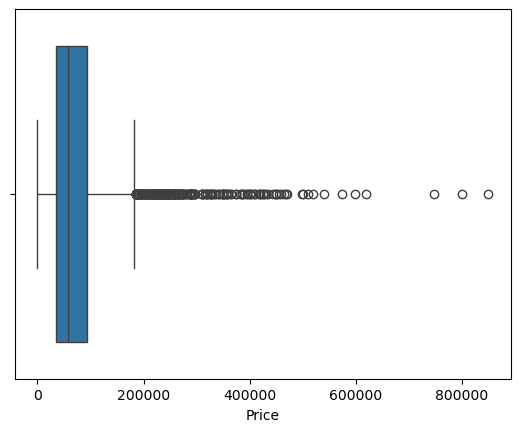

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df_nonnegotiable['Price'])
plt.show()

Bisa terlihat untuk harga - harga dari dataset Non-Negotiable, ada beberapa outlier yang tinggi. Dikarenakan listing outlier sangat berpengaruh untuk prediction power model yang ingin dibuat, dibuat data-handling dengan cara mengatur batas tinggi harga yang dimasuki dalam model yang akan digunakan. Batas tinggi secara statistik yang digunakan adalah Q3 + 3*IQR terlihat dibawah

In [6]:
Q1 = df_nonnegotiable['Price'].quantile(0.25)
Q3 = df_nonnegotiable['Price'].quantile(0.75)
IQR = Q3 - Q1

upper_limit_extreme = Q3 + 3 * IQR

print(f"Upper Limit is:{upper_limit_extreme}")
high_price_listings = df_nonnegotiable[df_nonnegotiable['Price'] > upper_limit_extreme]
high_price_listings

Upper Limit is:272000.0


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
233,GLE,Riyadh,Mercedes,Automatic,Other,Full,2020,6.9,24000,False,330000
246,CLA,Riyadh,Mercedes,Automatic,Other,Full,2020,2.0,15000,False,410000
251,Vanquish,Dammam,Aston Martin,Automatic,Saudi,Full,2013,6.0,32000,False,400000
362,The 7,Riyadh,BMW,Automatic,Gulf Arabic,Full,2019,2.0,6000,False,335000
526,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.6,18000,False,285000
...,...,...,...,...,...,...,...,...,...,...,...
5149,LX,Riyadh,Lexus,Automatic,Gulf Arabic,Full,2020,5.7,105,False,425000
5246,Yukon,Aseer,GMC,Automatic,Saudi,Full,2021,5.3,3700,False,310000
5423,GTB 599 Fiorano,Dammam,Ferrari,Automatic,Saudi,Full,2008,6.0,59000,False,280000
5487,IS,Jeddah,Lexus,Automatic,Saudi,Full,2018,3.5,54000,False,275000


In [7]:
df_nonnegotiable = df_nonnegotiable[df_nonnegotiable['Price'] <= upper_limit_extreme]

Non-negotiable listings: 3723


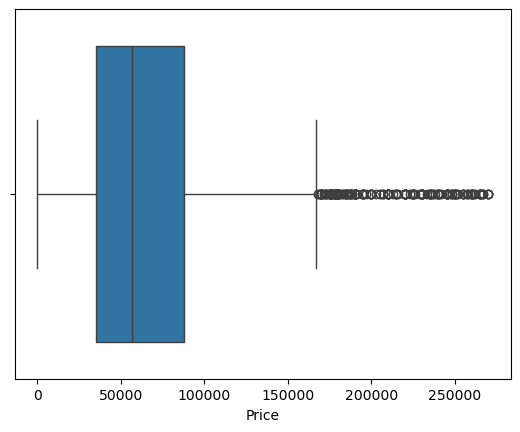

In [8]:
print("Non-negotiable listings:", len(df_nonnegotiable))
sns.boxplot(x=df_nonnegotiable['Price'])
plt.show()

Terlihat dari Boxplot diatas, sudah tidak ada outlier di bagian Price

### Data Plotting

Di bagian ini akan memulai plotting agar bisa lebih mengerti dataset, dan juga memvisualisasikan jika ada dataset yang perlu diproses.

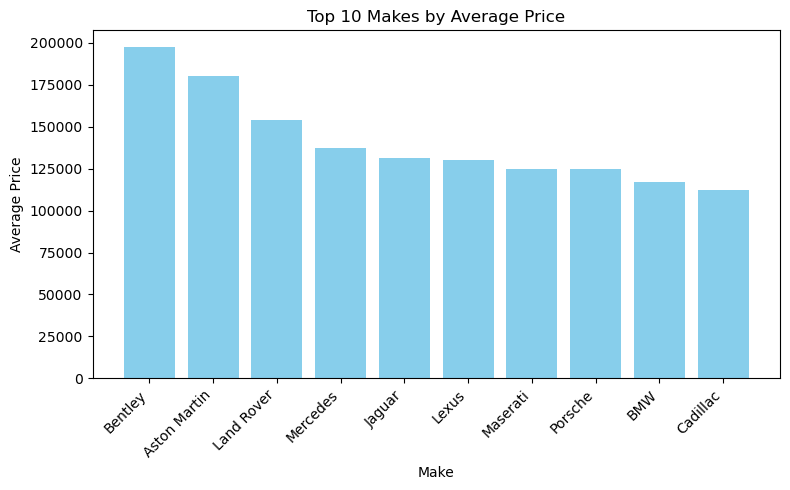

In [9]:
import matplotlib.pyplot as plt

avg_price_make = df_nonnegotiable.groupby('Make')['Price'].mean().reset_index()
avg_price_make = avg_price_make.sort_values('Price', ascending=False).head(10)

plt.figure(figsize=(8, 5))
plt.bar(avg_price_make['Make'], avg_price_make['Price'], color='skyblue')
plt.title("Top 10 Makes by Average Price")
plt.xlabel("Make")
plt.ylabel("Average Price")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Terlihat dari histogram diatas, menampilkan merk mobil dengan rata - rata harga tertinggi (top 10). Bentley merupakan merk mobil dengan rata - rata harga tertinggi (jika dibandingkan merk lain)

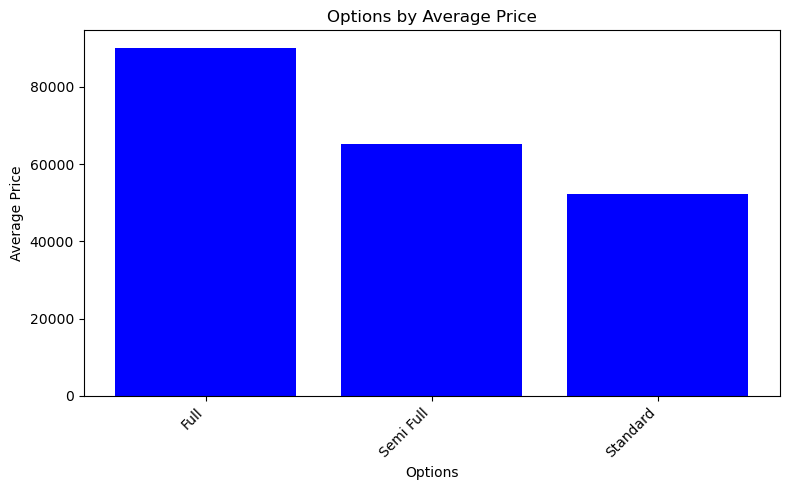

In [10]:
avg_price_options = df_nonnegotiable.groupby('Options')['Price'].mean().reset_index()


plt.figure(figsize=(8, 5))
plt.bar(avg_price_options['Options'], avg_price_options['Price'], color='blue')
plt.title("Options by Average Price")
plt.xlabel("Options")
plt.ylabel("Average Price")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Diatas merupakan Histogram dari "Options", untuk hasilnya sesuai ekspektasi karena memang seharusnya options Full lebih mahal dari Semi Full; dan Semi Full lebih mahal dari Standard.

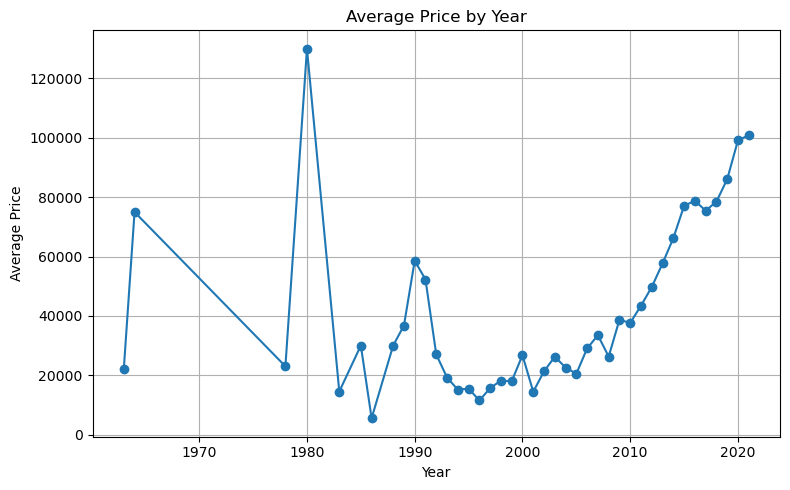

In [11]:
avg_price_year = df_nonnegotiable.groupby('Year')['Price'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(avg_price_year['Year'], avg_price_year['Price'], marker='o')
plt.title("Average Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

Untuk line Chart diatas, bisa terlihat tepat di tahun 1980, ada "spike" dari rata - rata harga. Ini kemungkinan terjadi karena mayoritas mobil bekas di tahun 1980 kebetulan masuk ke arah "classic car". Untuk itu data tidak diproses.

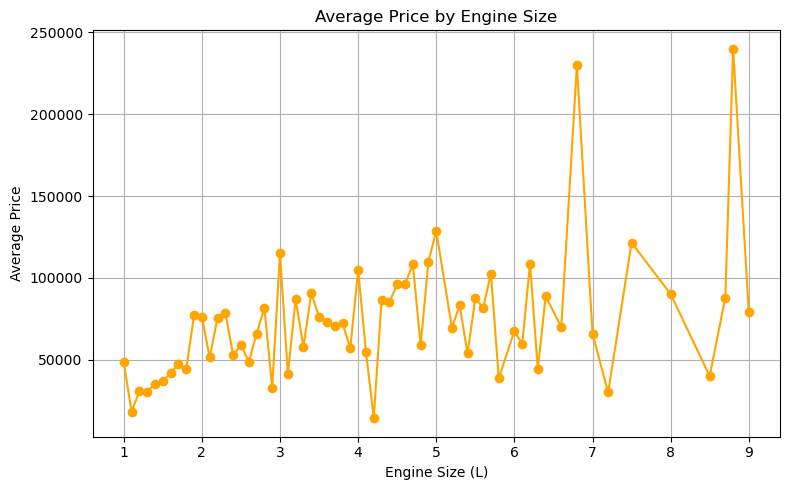

In [12]:
avg_price_engine = df_nonnegotiable.groupby('Engine_Size')['Price'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(avg_price_engine['Engine_Size'], avg_price_engine['Price'], marker='o', color='orange')
plt.title("Average Price by Engine Size")
plt.xlabel("Engine Size (L)")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

Ini menunjukkan rata - rata harga dari berbagai Engine Size.

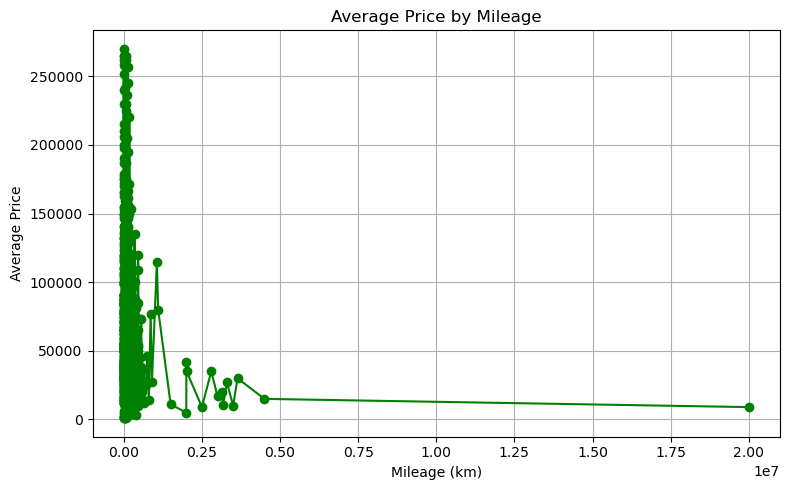

In [13]:
avg_price_mileage = df_nonnegotiable.groupby('Mileage')['Price'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(avg_price_mileage['Mileage'], avg_price_mileage['Price'], marker='o', color='green')
plt.title("Average Price by Mileage")
plt.xlabel("Mileage (km)")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

Dikarenakan terlihat ada listing dengan Mileage yang memiliki nilai 20 juta Kilometer, saya akan menghapus listing ini dikarenakan ini jelas - jelas outlier yang bisa berpengaruh terhadap model.

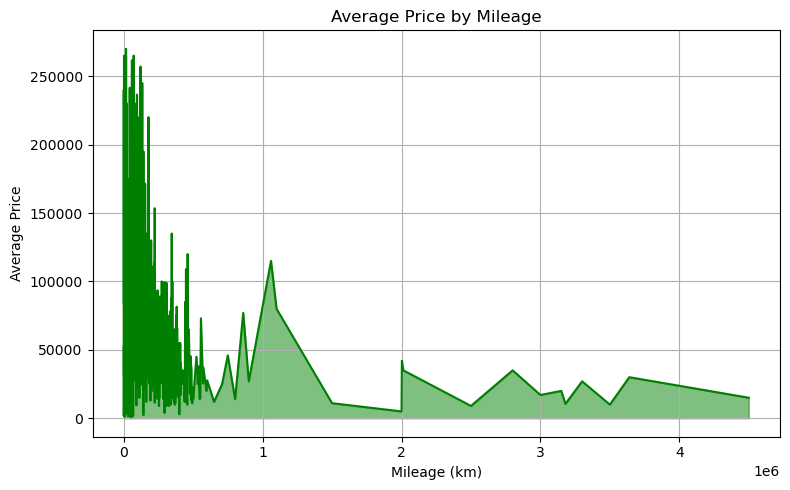

In [14]:
df_nonnegotiable = df_nonnegotiable[df_nonnegotiable["Mileage"] < 10000000]

avg_price_mileage = df_nonnegotiable.groupby('Mileage')['Price'].mean().reset_index()
avg_price_mileage = avg_price_mileage.sort_values('Mileage')


plt.figure(figsize=(8, 5))
plt.fill_between(avg_price_mileage["Mileage"], avg_price_mileage["Price"], color="green", alpha=0.5)
plt.plot(avg_price_mileage['Mileage'], avg_price_mileage['Price'], color='green')
plt.title("Average Price by Mileage")
plt.xlabel("Mileage (km)")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

Terlihat diatas adalah area chart dari rata - rata harga mobil dengan Mileage nya.

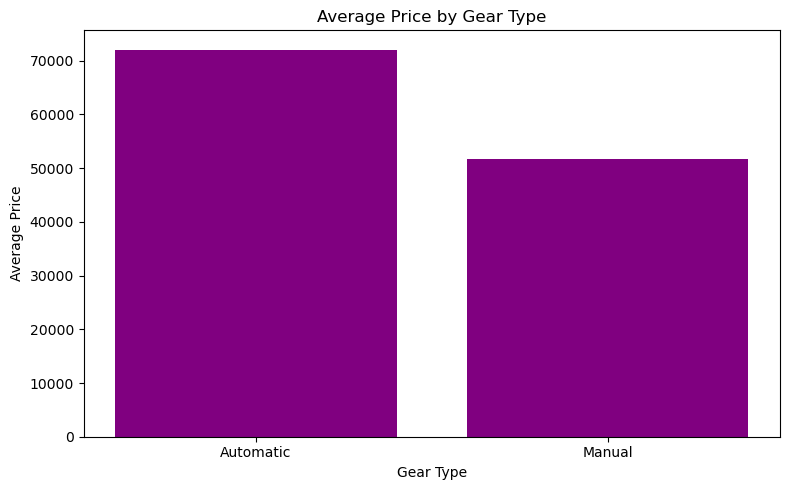

In [15]:
avg_price_gear = df_nonnegotiable.groupby('Gear_Type')['Price'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(avg_price_gear['Gear_Type'], avg_price_gear['Price'], color='purple')
plt.title("Average Price by Gear Type")
plt.xlabel("Gear Type")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()

Bar chart diatas menunjukkan rata - rata harga dari mobil automatic dan mobil manual. 

### Machine Learning

Untuk seleksi fitur yang digunakan, lebih mudah menjelaskan fitur yang tidak digunakan:

Region & Origin --> Tidak digunakan karena start-up Mobil99 berencana mengambil semua region di Saudi Arabia.

Dilakukan berbagai model Machine Learning, yaitu:
- Random Forest Regressor
- Linear Regression
- Decision Tree Regression
- Gradient Boosting Regression

In [16]:
X = df_nonnegotiable[['Type','Make', 'Year', 'Engine_Size', 'Mileage', 'Gear_Type','Options']]
y = df_nonnegotiable['Price']

#### Random Forest Regressor

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

categorical_cols = ['Type','Make', 'Gear_Type','Options']
numerical_cols = ['Year', 'Engine_Size', 'Mileage']

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols), ('num', 'passthrough', numerical_cols)])

model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', RandomForestRegressor(random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"R² score: {score:.2f}")

R² score: 0.77


In [18]:
from sklearn.metrics import mean_absolute_error

y_predrf = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predrf)
print(f"Mean Absolute Error: {mae:,.0f}")

Mean Absolute Error: 12,515


#### Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lin_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])

lin_model.fit(X_train, y_train)

y_predlin = lin_model.predict(X_test)

print("Linear Regression")
print(f"R² score: {r2_score(y_test, y_predlin):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_predlin):,.0f}")

Linear Regression
R² score: 0.31
Mean Absolute Error: 27,864


#### Decision Tree Regressor

In [20]:
from sklearn.tree import DecisionTreeRegressor

dt_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', DecisionTreeRegressor(random_state=42))])

dt_model.fit(X_train, y_train)

y_preddt = dt_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score
print("Decision Tree Regressor")
print(f"R² score: {r2_score(y_test, y_preddt):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_preddt):,.0f}")

Decision Tree Regressor
R² score: 0.62
Mean Absolute Error: 17,010


#### Gradient Boosting Regressor

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', GradientBoostingRegressor(random_state=42))])

gb_model.fit(X_train, y_train)

y_predgb = gb_model.predict(X_test)

print("Gradient Boosting Regressor")
print(f"R² score: {r2_score(y_test, y_predgb):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_predgb):,.0f}")

Gradient Boosting Regressor
R² score: 0.77
Mean Absolute Error: 14,401


#### Support Vector Regressor

In [22]:
from sklearn.svm import SVR

svr_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', SVR(kernel='rbf'))])

svr_model.fit(X_train, y_train)

y_predsvr = svr_model.predict(X_test)

print("Support Vector Regressor (SVR)")
print(f"R² score: {r2_score(y_test, y_predsvr):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_predsvr):,.0f}")

Support Vector Regressor (SVR)
R² score: -0.07
Mean Absolute Error: 34,995


### Evaluation Matrix

Dilakukan Evaluation Matrix dari model - model yang sudah dilakukan diatas.

In [23]:
results = []

results.append({"Model": "Random Forest","R²": r2_score(y_test, y_predrf),"MAE": mean_absolute_error(y_test, y_predrf)})
results.append({"Model": "Decision Tree","R²": r2_score(y_test, y_preddt),"MAE": mean_absolute_error(y_test, y_preddt)})
results.append({"Model": "Linear Regression","R²": r2_score(y_test, y_predlin),"MAE": mean_absolute_error(y_test, y_predlin)})
results.append({"Model": "Gradient Boosting","R²": r2_score(y_test, y_predgb),"MAE": mean_absolute_error(y_test, y_predgb)})
results.append({"Model": "SVR","R²": r2_score(y_test, y_predsvr),"MAE": mean_absolute_error(y_test, y_predsvr)})

eval_matrix = pd.DataFrame(results)
print(eval_matrix)

               Model        R²           MAE
0      Random Forest  0.773736  12514.656911
1      Decision Tree  0.621430  17009.779866
2  Linear Regression  0.308955  27864.346907
3  Gradient Boosting  0.772919  14401.091137
4                SVR -0.067303  34994.960436


Dari Hasil Evaluation Matrix diatas, bisa dilihat kalau Random Forest dan Gradient Boosting memiliki performa yang paling bagus jika dilihat dari Score R-squared dan Mean Absolute Error nya.

Skor R-squared menilai jumlah Variance (variasi) dari data harga, semakin tinggi skor R-squared semakin besar presentase dari variasi harga yang terdapat di model
Mean Absolute Error menunjukkan nilai dari rata - rata error nilai "Price" dari prediksi yang dihasilkan (semakin kecil nilai MAE semakin baik)

Sehingga model Random Forest Regressor menjadi model terbaik untuk kasus ini.

### Cross-Evaluation

Cross Evaluation digunakan agar perbandingan model bisa lebih dipercaya.

In [24]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_cv = []

rf_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')
rf_mae = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
results_cv.append({"Model": "Random Forest","CV R² (mean)": rf_r2.mean(),"CV R² (std)": rf_r2.std(),"CV MAE (mean)": rf_mae.mean()})

dt_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', DecisionTreeRegressor(random_state=42))])
dt_r2 = cross_val_score(dt_model, X, y, cv=kf, scoring='r2')
dt_mae = -cross_val_score(dt_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
results_cv.append({"Model": "Decision Tree","CV R² (mean)": dt_r2.mean(),"CV R² (std)": dt_r2.std(),"CV MAE (mean)": dt_mae.mean()})

lin_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])
lin_r2 = cross_val_score(lin_model, X, y, cv=kf, scoring='r2')
lin_mae = -cross_val_score(lin_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
results_cv.append({"Model": "Linear Regression","CV R² (mean)": lin_r2.mean(),"CV R² (std)": lin_r2.std(),"CV MAE (mean)": lin_mae.mean()})

gb_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', GradientBoostingRegressor(random_state=42))])
gb_r2 = cross_val_score(gb_model, X, y, cv=kf, scoring='r2')
gb_mae = -cross_val_score(gb_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
results_cv.append({"Model": "Gradient Boosting","CV R² (mean)": gb_r2.mean(),"CV R² (std)": gb_r2.std(),"CV MAE (mean)": gb_mae.mean()})

svr_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', SVR(kernel='rbf'))])
svr_r2 = cross_val_score(svr_model, X, y, cv=kf, scoring='r2')
svr_mae = -cross_val_score(svr_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
results_cv.append({"Model": "SVR","CV R² (mean)": svr_r2.mean(),"CV R² (std)": svr_r2.std(),"CV MAE (mean)": svr_mae.mean()})

cv_eval_matrix = pd.DataFrame(results_cv)
print(cv_eval_matrix)

               Model  CV R² (mean)  CV R² (std)  CV MAE (mean)
0      Random Forest      0.797372     0.021179   13239.577510
1      Decision Tree      0.658209     0.030412   17319.965129
2  Linear Regression      0.345335     0.029494   28333.584063
3  Gradient Boosting      0.783355     0.019244   15320.224313
4                SVR     -0.068301     0.015310   36169.848255


Setelah dilakukan Cross Evaluation dengan model - model diatas, bisa diliihat kalau metode Random Forest Regressor memiliki nilai R-Squared (mean) lebih tinggi dari Gradient Boosting.

Sehingga bisa dipastikan kalau model Random Forest Regressor lebih bisa memprediksi dengan lebih akurat jika dibandingkan dengan model lain yang digunakan disini.

### HyperParameter Tuning

Dilakukan Hyperparameter tuning terhadap metode Random Forest Regressor (karena setelah dibandingkan dengan evaluation matrix dan cross evaluation, model Random Forest Regressor terbukti paling baik).

In [25]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2']
}

In [26]:
from sklearn.model_selection import GridSearchCV

grid_search_mae = GridSearchCV(
    estimator=model,  #variabel (model) adalah Random Forest Regressor yang digunakan diatas
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error', 
    n_jobs=-1,
    verbose=2
)


grid_search_mae.fit(X_train, y_train)


print("Best Parameters (MAE):", grid_search_mae.best_params_)
print("Best Cross-Validated MAE:", -grid_search_mae.best_score_)


best_rf_mae = grid_search_mae.best_estimator_
y_pred_best_mae = best_rf_mae.predict(X_test)

print("Test MAE:", mean_absolute_error(y_test, y_pred_best_mae))
print("Test R²:", r2_score(y_test, y_pred_best_mae))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters (MAE): {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best Cross-Validated MAE: 14230.089552780842
Test MAE: 12927.89669223394
Test R²: 0.793909168600097


In [27]:
results.append({"Model": "Random Forest (Tuned)","R²": r2_score(y_test, y_pred_best_mae),"MAE": mean_absolute_error(y_test, y_pred_best_mae)})
eval_matrix = pd.DataFrame(results)
print(eval_matrix)

                   Model        R²           MAE
0          Random Forest  0.773736  12514.656911
1          Decision Tree  0.621430  17009.779866
2      Linear Regression  0.308955  27864.346907
3      Gradient Boosting  0.772919  14401.091137
4                    SVR -0.067303  34994.960436
5  Random Forest (Tuned)  0.793909  12927.896692


Setelah dilakukan hyperparameter tuning, bisa dilihat skor r-squared nya lebih baik (dapat melihat pola dari nilai harga lebih baik) namun skor Mean Absolute Error nya juga naik sehingga hasil setiap prediksi nya lebih tidak akurat. Sehingga dinilai lebih baik menggunakan random forest sebelum di-tuning (original Random Forest Regressor). Karena menurut perumusan masalah yang digunakan, model ini dibuat untuk me-listing mobil yang akan dijual. Jadi, metric Mean Absolute Error digunakan sebagai pembanding yang lebih penting.

## Kesimpulan

Setelah melakukan berbagai model machine learning untuk memprediksi harga mobil yang akan dijual, metode Random Forest Regressor menjadi algoritma terbaik untuk digunakan.

Walaupun setelah melakukan Hyperparameter-Tuning terhadap metode Random Forest Regressor, dikarenakan hanya nilai R-squared nya saja yang membaik sedangkan nilai Mean Absolute Error nya memburuk; metode Random Forest Regressor sebelum dilakukan tuning lebih baik dalam memprediksi harga.

### Prediction Example

Disini bisa secara manual menaruh fitur - fitur yang nanti akan diprediksi berapa Harga dari listing dengan fitur sedemikian rupa.

In [28]:
example = pd.DataFrame([{
    'Type':"Carnival",
    'Year': 2019,
    'Engine_Size': 1,
    'Mileage': 10000,
    'Make': 'Kia',
    'Gear_Type': 'Automatic',
    'Options': 'Standard'
}])

predicted_price = model.predict(example)[0]
print(f"Predicted Price: {predicted_price:,.0f}")

Predicted Price: 41,493
